# Summarise and plot IOS analysis

In this notebook we plot the long-term average phenology across Australia, the long-term trends, and a number of plots that show the phenology time-series across Australia to show examples of change.

In [1]:
import os
import sys
import xvec
import pickle
import textwrap
import warnings
import distinctipy
import numpy as np
import xarray as xr
import pandas as pd
import seaborn as sb
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
from odc.geo.xr import assign_crs
import matplotlib.colors as colors
import matplotlib.ticker as ticker
from scipy.interpolate import griddata
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

import sys
sys.path.append('/g/data/os22/chad_tmp/AusEFlux/src/')
from _utils import round_coords
from _prediction import allNaN_arg

import sys
sys.path.append('/g/data/os22/chad_tmp/Aus_phenology/src')
from phenology_pixel import xr_phenometrics

%matplotlib inline

/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'ucx' has been deprecated; please use 'distributed.comm.ucx' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/g/data/os22/chad_tmp/AusENDVI/env/py310/lib/python3.10/site-packages/dask/config.py:779: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


## Open per pixel phenology data

In [2]:
p_ios = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/ios_analysis_perpixel.nc'), crs='EPSG:4326')
p_average = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/mean_phenology_perpixel.nc'), crs='EPSG:4326')
p_trends = assign_crs(xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/results/trends_phenology_perpixel.nc'), crs='EPSG:4326')

gdf = gpd.read_file('/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson')

# cropping for masking
crops = xr.open_dataset('/g/data/os22/chad_tmp/Aus_phenology/data/croplands_5km.nc')['croplands']
crops = xr.where(crops==3, 0, 1) #rainfed crops
crops = round_coords(crops)

In [3]:
p_ios = p_ios.where(crops)
p_average = p_average.where(crops)
p_trends = p_trends.where(crops)

ios_most_important_var = allNaN_arg(p_ios[['vPOS_parcorr', 'LOS_parcorr']].to_array(), dim='variable',stat='max', idx=False)

## IOS and vPOS*LOS

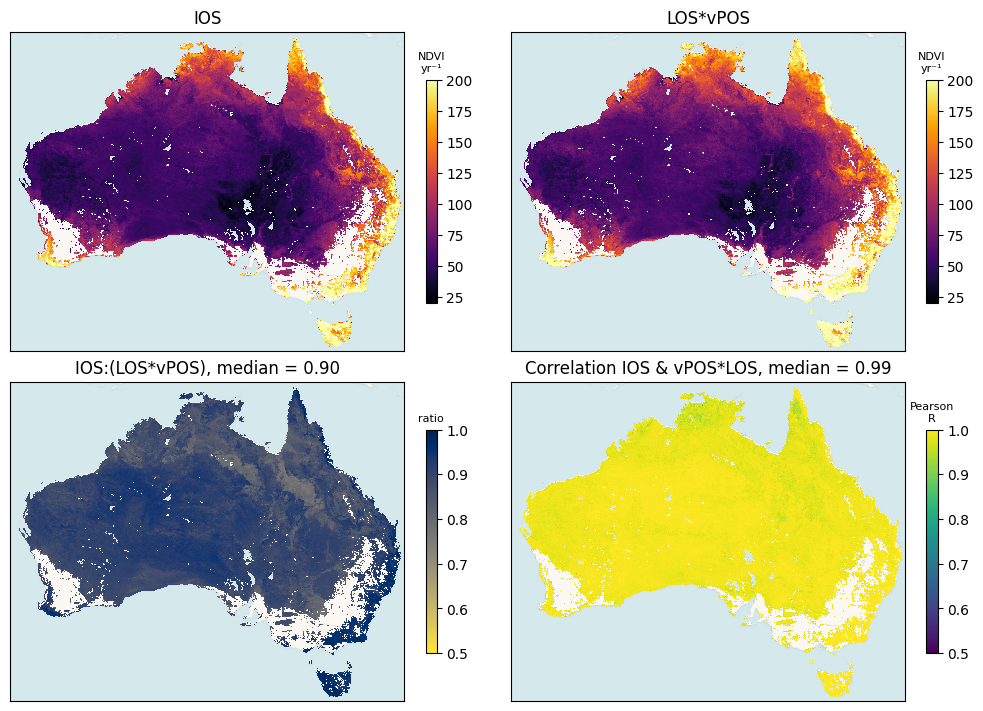

In [4]:
vars=['IOS', 'LOS*vPOS','IOS:(LOS*vPOS)', 'pearson_r_IOS_vs_LOS*vPOS']

fig,axes=plt.subplots(2,2,figsize=(10,7), layout='constrained', sharey=True)

for v,ax in zip(vars, axes.ravel()):
    if v=='IOS:(LOS*vPOS)':
        cmap='cividis_r'
        vmin=0.5
        vmax=1
        t=v+ ', median = 0.90'
        l='ratio'

    if any(v in s for s in ['IOS','LOS*vPOS']):
        cmap='inferno'
        vmin=20
        vmax=200
        t = v
        l='NDVI\nyr⁻¹'
    
    if v == 'pearson_r_IOS_vs_LOS*vPOS':
        cmap='viridis'
        vmin=0.5
        vmax=1
        t='Correlation IOS & vPOS*LOS, median = 0.99'
        l='Pearson\nR'

    if v == 'pearson_r_IOS_vs_LOS*vPOS':
        im=p_ios[v].plot(cmap=cmap, vmin=vmin,vmax=vmax, robust=True, ax=ax, add_labels=False,add_colorbar=False)
    
    else:
        im=p_average[v].plot(cmap=cmap, vmin=vmin,vmax=vmax, robust=True, ax=ax, add_labels=False,add_colorbar=False)
    
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_title(t, fontsize=12)
    norm = colors.Normalize(vmin=vmin, vmax=vmax)
    cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
    ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7)
    ax_cbar.ax.set_title(l, fontsize=8)
    
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/IOS_LOSvPOS_ratio.png',
            bbox_inches='tight', dpi=300)

## Partial correlations with IOS

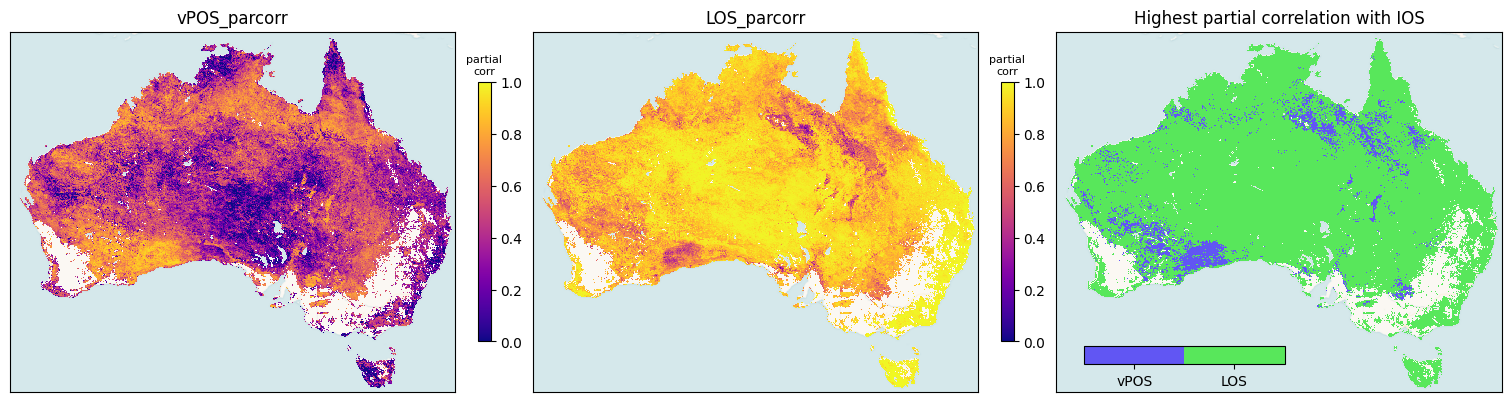

In [5]:
vars=['vPOS_parcorr', 'LOS_parcorr', 'Highest partial correlation with IOS']

categories = ['vPOS', 'LOS']
colours1 = distinctipy.get_colors(len(categories), pastel_factor=0.5, rng=2)
cmap1 = LinearSegmentedColormap.from_list("cwc", colours1, N=len(categories))

fig,axes=plt.subplots(1,3,figsize=(15,4), layout='constrained', sharey=True)

for v,ax in zip(vars, axes.ravel()):
    if v=='Highest partial correlation with IOS':
        cmap='cividis_r'
        vmin=0
        vmax=1
        t=v
        # im = ios_most_important_var.where(p_trends.vPOS_p_value <0.05).plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmap1)
        im = ios_most_important_var.plot(ax=ax, add_colorbar=False, add_labels=False, cmap=cmap1)
        axins1 = inset_axes(ax,width="45%",height="5%",loc="lower left", borderpad=2)
        cbar = fig.colorbar(im, cax=axins1, ticks=[0.25,0.75], orientation='horizontal')
        cbar.ax.set_xticklabels(['vPOS', 'LOS']);
    else:
        cmap='plasma'
        vmin=0
        vmax=1
        t = v
        l='partial\ncorr'
        # im=p_ios[v].where(p_trends.vPOS_p_value <0.05).plot(cmap=cmap, vmin=vmin,vmax=vmax, robust=True, ax=ax, add_labels=False,add_colorbar=False)
        im=p_ios[v].plot(cmap=cmap, vmin=vmin,vmax=vmax, robust=True, ax=ax, add_labels=False,add_colorbar=False)
        norm = colors.Normalize(vmin=vmin, vmax=vmax)
        cbar = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
        ax_cbar = fig.colorbar(cbar, ax=ax, shrink=0.7)
        ax_cbar.ax.set_title(l, fontsize=8)
    
    ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
    ax.axes.get_xaxis().set_ticks([])
    ax.axes.get_yaxis().set_ticks([])
    ax.set_title(t, fontsize=12)
    
fig.savefig(f'/g/data/os22/chad_tmp/Aus_phenology/results/figs/IOS_parcorr.png',
            bbox_inches='tight', dpi=300)

## Examples of disconnection between positive vPOS trends and IOS


In [6]:
base = '/g/data/os22/chad_tmp/Aus_phenology/'
ds_path = '/g/data/os22/chad_tmp/AusENDVI/results/publication/AusENDVI-clim_MCD43A4_gapfilled_1982_2022.nc'
timeseries_file =f'{base}data/pickle/IBRA_subregions_climate.pkl'
ecoregions_file = '/g/data/os22/chad_tmp/Aus_phenology/data/vectors/IBRAv7_subregions_modified.geojson'
phenometrics_file = f'{base}data/pickle/IBRA_subregions_AusENDVI-clim_MCD43A4_phenometrics.pkl'
var='SUB_NAME_7'

with open(phenometrics_file, 'rb') as f:
    phenometrics = pickle.load(f)

gdf = gdf[gdf[var].isin(list(phenometrics.keys()))]

In [7]:
disconnected_from_vPOS = ['Warre', 'Daintree-Bloomfield', 'Weipa Plateau', 'Dalmorto', 'Otway Ranges', 'West'] #South East Coastal Ranges
connected_to_vPOS = ['Barkly Tableland', 'Claraville Plains', 'McArthur', 'Mitchell']

# gdf_dis = gdf[gdf['SUB_NAME_7'].isin(disconnected_from_vPOS)].reset_index(drop=True)

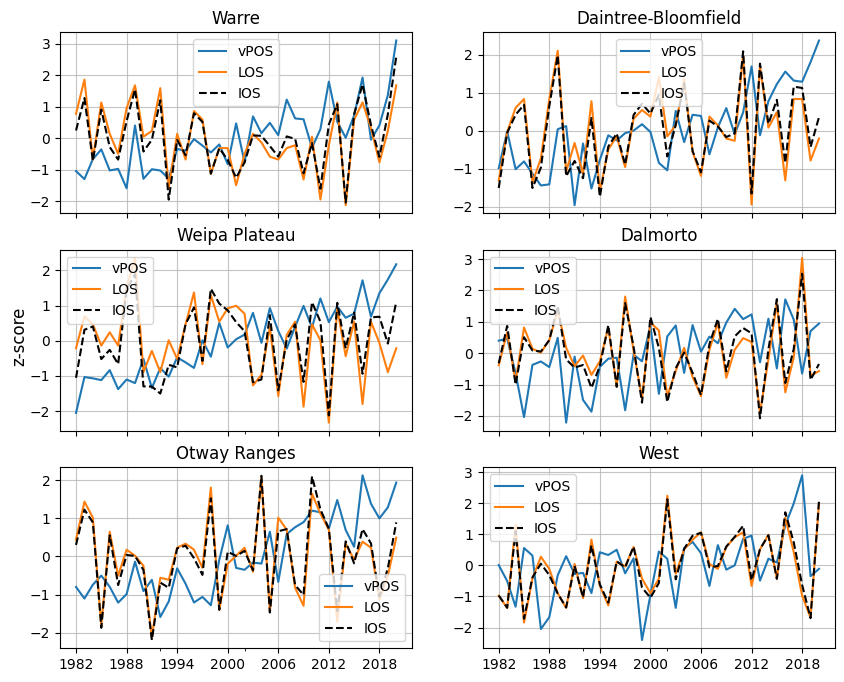

In [8]:
fig,axes = plt.subplots(3,2, figsize=(10,8), sharex=True)

for region, ax in zip(disconnected_from_vPOS, axes.ravel()):
    df = phenometrics[region]
    # df = df.rolling(5).mean()
    ((df.vPOS - df.vPOS.mean()) / df.vPOS.std()).plot(ax=ax, label='vPOS')
    ((df.LOS - df.LOS.mean()) / df.LOS.std()).plot(ax=ax, label='LOS')
    ((df.IOS - df.IOS.mean()) / df.IOS.std()).plot(ax=ax, label='IOS', c='black', linestyle='--')
    ax.grid(alpha=0.75)
    ax.set_title(region)
    ax.set_ylabel(None)
    ax.legend()
    ax.set_xticks(ticks = range(0,40, 6), labels=range(1982,2022, 6));
fig.supylabel('z-score', x=0.075);

[]

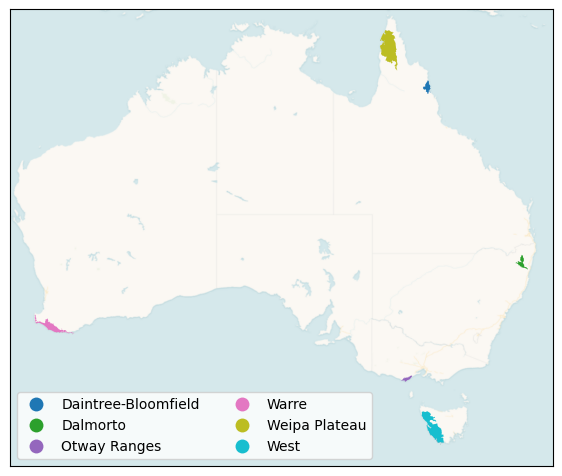

In [9]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
gdf_dis = gdf[gdf['SUB_NAME_7'].isin(disconnected_from_vPOS)].reset_index(drop=True)

gdf_dis.plot(column='SUB_NAME_7', ax=ax, legend=True, legend_kwds ={'ncols':2, 'loc':'lower left'})
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax.axes.get_xaxis().set_ticks([])
ax.axes.get_yaxis().set_ticks([])

### Is this a trend for all high tree fraction regions?

In [30]:
trees = xr.open_dataset('/g/data/os22/chad_tmp/AusENDVI/data/5km/trees_5km_monthly_1982_2022.nc')['trees']
trees = trees.mean('time')
tree_mask = xr.where(trees>=0.5, 1, 0)

#and significant change in vPOS
tree_mask = ((tree_mask) & (p_trends.vPOS_p_value <=0.05))

In [31]:
ds_path = '/g/data/os22/chad_tmp/Aus_phenology/data/NDVI/NDVI_smooth_AusENDVI-clim_MCD43A4.nc'
ds = xr.open_dataarray(ds_path)
ds = ds.where(tree_mask)
ds = ds.mean(['latitude', 'longitude'])
times_to_keep = ds.dropna(dim='time',how='any').time
ds = ds.sel(time=times_to_keep)
ds = ds.resample(time='1D').interpolate(kind='quadratic').astype('float32')

In [32]:
#run the phenometrics
ds_phen= xr_phenometrics(ds.expand_dims(latitude=[-33], longitude = [125]),
                  rolling=90,
                  distance=90,
                  prominence='auto',
                  plateau_size=10,
                  amplitude=0.20
                 ).compute()
        

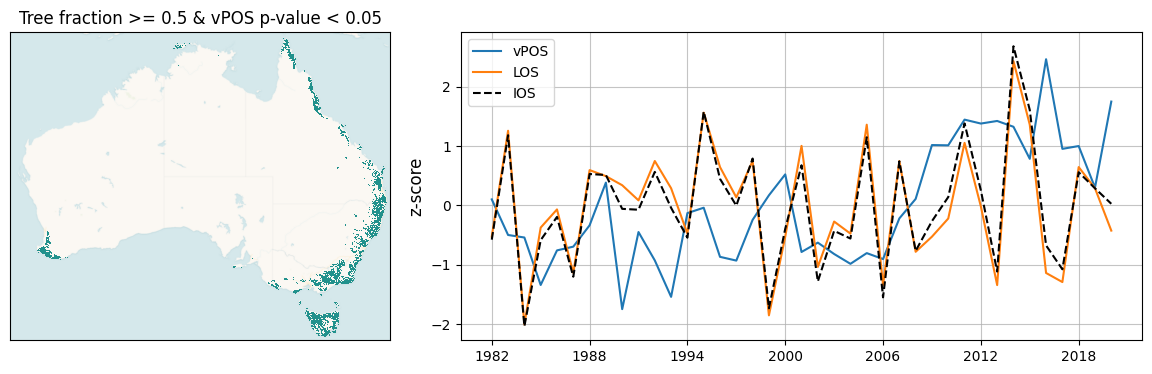

In [33]:
layout = [
    ['A','A' ,'B', 'B','B'],
]

fig, ax = plt.subplot_mosaic(layout, figsize=(15, 4))

df = ds_phen.squeeze().to_dataframe()
# df = df.rolling(3).mean()
tree_mask.where(tree_mask==1).plot(ax=ax['A'], add_colorbar=False, add_labels=False)
ctx.add_basemap(ax['A'], source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)
ax['A'].axes.get_xaxis().set_ticks([])
ax['A'].axes.get_yaxis().set_ticks([])
ax['A'].set_title('Tree fraction >= 0.5 & vPOS p-value < 0.05')

((df.vPOS - df.vPOS.mean()) / df.vPOS.std()).plot(ax=ax['B'], label='vPOS')
((df.LOS - df.LOS.mean()) / df.LOS.std()).plot(ax=ax['B'], label='LOS')
((df.IOS - df.IOS.mean()) / df.IOS.std()).plot(ax=ax['B'], label='IOS', c='black', linestyle='--')
ax['B'].grid(alpha=0.75)
ax['B'].set_xlabel(None)
ax['B'].set_ylabel('z-score',fontsize=12 )
ax['B'].legend()
ax['B'].set_xticks(ticks = range(0,40, 6), labels=range(1982,2022, 6));

In [ ]:
p_ios[v].where(p_trends.vPOS_p_value <0.05).plot(cmap=cmap, vmin=vmin,vmax=vmax, robust=True, ax=ax, add_labels=False,add_colorbar=False)

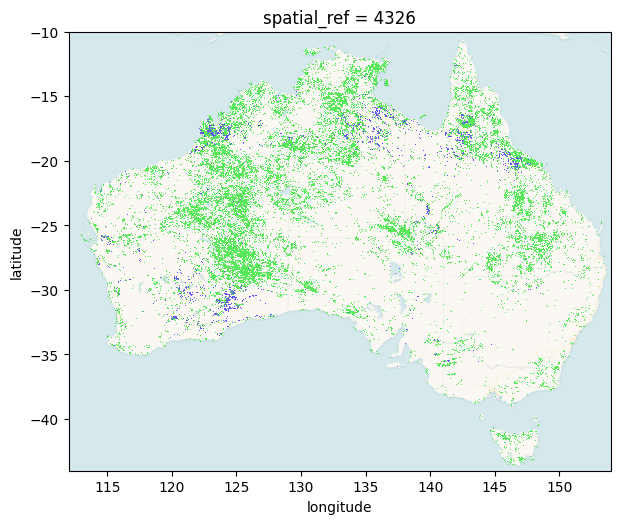

In [37]:
fig,ax = plt.subplots(1,1, figsize=(7,7))
ios_most_important_var.where(p_trends.IOS_p_value <0.05).plot(cmap=cmap1, ax=ax, add_colorbar=False)
ctx.add_basemap(ax, source=ctx.providers.CartoDB.VoyagerNoLabels, crs='EPSG:4326', attribution='', attribution_size=1)

In [ ]:



# gdf_dis.explore(col='SUB_NAME_7',
#             tiles = 'https://server.arcgisonline.com/ArcGIS/rest/services/World_Imagery/MapServer/tile/{z}/{y}/{x}',
#             attr = 'Esri',
#             name = 'Esri Satellite',
#            )

In [ ]:
# region='Wilto'

# for index, row in gdf.iterrows():
#     if row[var] == region:
#         df = phenometrics[row[var]]
#         # df = df.rolling(5).mean()

# fig,ax = plt.subplots(1,1, figsize=(7,4), sharex=True)
# ((df.vPOS - df.vPOS.mean()) / df.vPOS.std()).plot(ax=ax, label='vPOS')
# ((df.LOS - df.LOS.mean()) / df.LOS.std()).plot(ax=ax, label='LOS')
# ((df.IOS - df.IOS.mean()) / df.IOS.std()).plot(ax=ax, label='IOS', c='black', linestyle='--')
# ax.grid(alpha=0.75)
# ax.set_title(region)
# ax.legend()
# ax.set_ylabel('z-score')
# ax.set_xticks(ticks = range(0,40, 6), labels=range(1982,2022, 6));
# # ax.set_ylim(-2,2)
